# Imports

In [1]:
# PyABC imports
from pyabc import (ABCSMC, Distribution, RV,
                   History, MedianEpsilon)
from pyabc.populationstrategy import ConstantPopulationSize, AdaptivePopulationSize
from pyabc.epsilon import MedianEpsilon
from pyabc.sampler import MulticoreEvalParallelSampler

In [2]:
# Custom imports
from ionchannelABC import (ion_channel_sum_stats_calculator,
                           IonChannelAcceptor,
                           IonChannelDistance,
                           EfficientMultivariateNormalTransition,
                           plot_parameter_sensitivity,
                           plot_distance_weights,
                           plot_parameters_kde)

INFO:myokit:Loading Myokit version 1.27.4


In [3]:
# Other necessary imports
import numpy as np
import subprocess
import pandas as pd
import io
import os
import tempfile

In [4]:
# Plotting imports
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config Inline.Backend.figure_format = 'retina'

# Create ion channel model

In [5]:
from channels.ina import ina as model
#model.sample({})

# Get experimental measurements

In [6]:
measurements = model.get_experiment_data()
obs = measurements.to_dict()['y']
exp = measurements.to_dict()['exp']
errs = measurements.to_dict()['errs']

# Set limits and generate uniform initial priors

In [7]:
limits = dict(g_Na=(0, 100),
              p1=(0, 100),
              p2=(-100, 0),
              p3=(-10, 10),
              p4=(0, 1000),
              p5=(-1, 0),
              p6=(0, 1),
              p7=(0, 100),
              q1=(0, 100),
              q2=(0, 10),
              q4=(0, 100),
              q5=(-100, 0),
              q6=(0, 10),
              q7=(0, 10),
              q8=(0, 100),
              q9=(-100, 0),
              q10=(0, 10),
              q11=(0, 1.0),
              q12=(0, 10),
              q13=(0, 1),
              r2=(-1, 0),
              r3=(0, 100),
              r4=(-10, 0),
              r5=(0, 10),
              r6=(0, 100),
              r7=(0, 1),
              r8=(0, 100),
              r9=(-10, 0),
              r10=(0, 1),
              r11=(0, 10),
              r12=(-1, 1),
              r13=(0, 1),
              r14=(-1, 1),
              r15=(-1, 1),
              r16=(0, 100))
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

# Test parameter sensitivity

In [8]:
parameters = ['ina.'+k for k in limits.keys()]

In [9]:
distance_fn=IonChannelDistance(
    obs=obs,
    exp_map=exp,
    err_bars=errs,
    err_th=0.1)

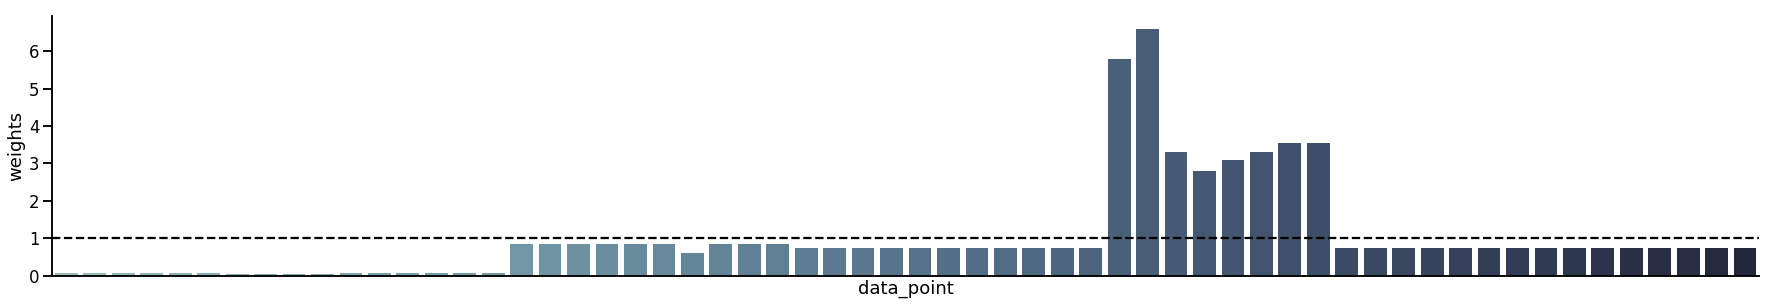

In [11]:
sns.set_context('talk')
g = plot_distance_weights(model, distance_fn)
g.savefig('results/ina/dist_weights.pdf')

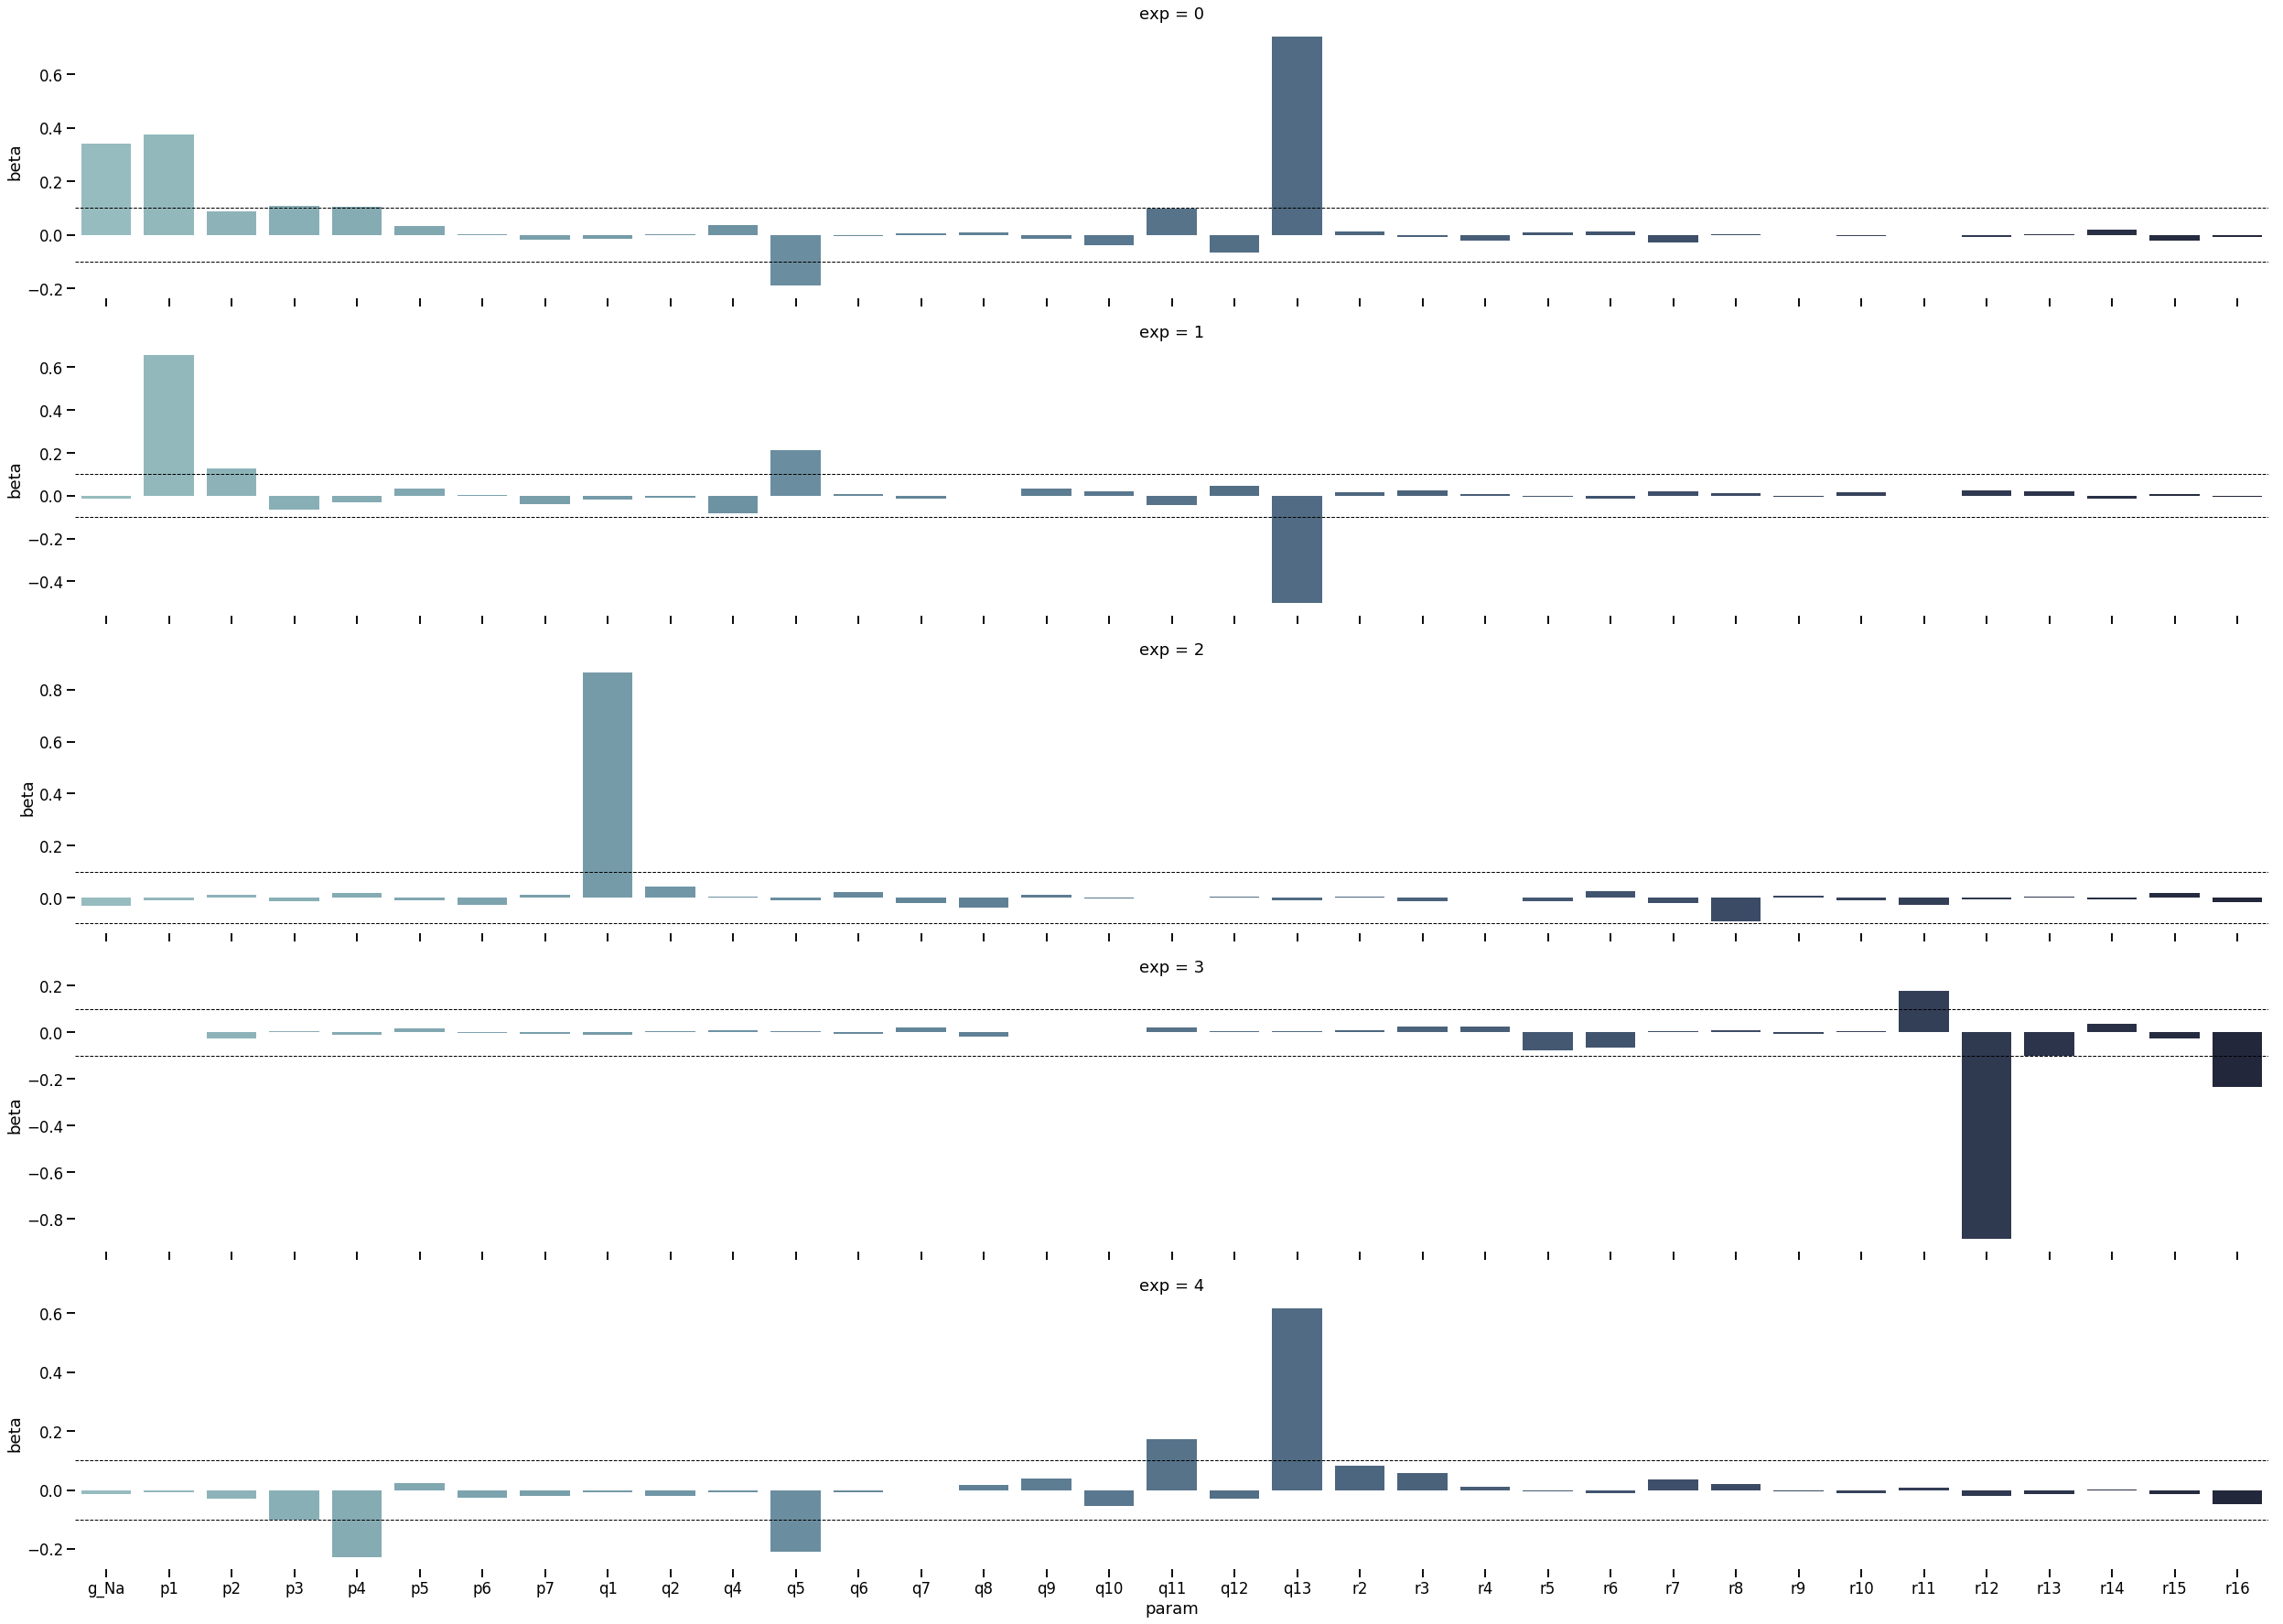

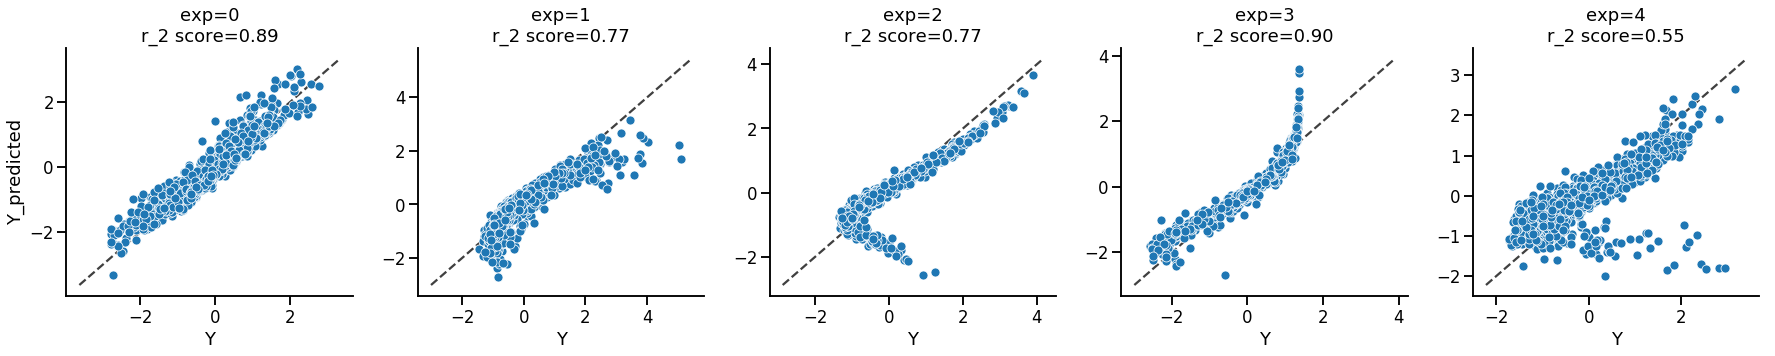

In [12]:
sns.set_context('talk')
grid1, grid2 = plot_parameter_sensitivity(
    model,
    parameters,
    distance_fn,
    sigma=0.1,
    n_samples=1000,
    plot_cutoff=0.1)

In [13]:
grid1.savefig('results/ina/sensitivity.pdf')
grid2.savefig('results/ina/sensitivity_fit.pdf')

In [7]:
limits = dict(g_Na=(0, 100),
              p1=(0, 100),
              p2=(-100, 0),
              p3=(-10, 10),
              p4=(0, 1000),
              q1=(0, 100),
              q5=(-100, 0),
              q11=(0, 1.0),
              q13=(0, 1),
              r8=(0, 100),
              r11=(0, 10),
              r12=(-1, 1),
              r13=(0, 1),
              r16=(0, 100))
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

# Initialise pyabc database

In [8]:
db_path = ('sqlite:///' + 
           os.path.join(tempfile.gettempdir(), "hl-1_ina.db"))
print(db_path)

sqlite:////scratch/cph211/tmp/hl-1_ina.db


In [9]:
# Let's log all the sh!t
import logging
logging.basicConfig()
abc_logger = logging.getLogger('ABC')
abc_logger.setLevel(logging.DEBUG)
eps_logger = logging.getLogger('Epsilon')
eps_logger.setLevel(logging.DEBUG)

In [10]:
abc = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 obs=obs,
                 exp_map=exp,
                 err_bars=errs,
                 err_th=0.1),
             #population_size=ConstantPopulationSize(
             #    nr_particles=10000),
             population_size=AdaptivePopulationSize(
                 start_nr_particles=2500,
                 mean_cv=0.5,
                 max_population_size=5000,
                 min_population_size=500),
             summary_statistics=ion_channel_sum_stats_calculator,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(),
             sampler=MulticoreEvalParallelSampler(n_procs=24),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {0: 0.05482047444775661, 1: 0.05482047444775661, 2: 0.05482047444775661, 3: 0.05482047444775661, 4: 0.05482047444775661, 5: 0.05482047444775661, 6: 0.04793030963340064, 7: 0.04260405991323703, 8: 0.0479278046958729, 9: 0.0536798519659175, 10: 0.05482047444775661, 11: 0.05482047444775661, 12: 0.05482047444775661, 13: 0.05482047444775661, 14: 0.05482047444775661, 15: 0.05482047444775661, 16: 0.8326197611814873, 17: 0.8326197611814873, 18: 0.8326197611814873, 19: 0.8326197611814873, 20: 0.8326197611814873, 21: 0.8326197611814873, 22: 0.6017669628485173, 23: 0.8326197611814873, 24: 0.8326197611814873, 25: 0.8326197611814873, 26: 0.7463215252566501, 27: 0.7463215252566501, 28: 0.7463215252566501, 29: 0.7463215252566501, 30: 0.7463215252566501, 31: 0.7463215252566501, 32: 0.7463215252566501, 33: 0.7463215252566501, 34: 0.7463215252566501, 35: 0.7463215252566501, 36: 0.7463215252566501, 37: 5.779317930650152, 38: 6.604934777885866, 39: 3.3021281756664393, 40: 2.

In [11]:
abc_id = abc.new(db_path, obs)

INFO:History:Start <ABCSMC(id=1, start_time=2018-09-05 09:59:04.679358, end_time=None)>
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/site-packages/pyabc-0.9.1-py3.6.egg/pyabc/epsilon.py:321: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  distances = weighted_distances.distance.as_matrix()
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/site-packages/pyabc-0.9.1-py3.6.egg/pyabc/epsilon.py:325: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  weights = weighted_distances.w.as_matrix()
INFO:Epsilon:initial epsilon is 130.77367811539395


In [31]:
history = abc.run(minimum_epsilon=0.05, max_nr_populations=30, min_acceptance_rate=0.001)

INFO:ABC:t:30 eps:1.7592378132649185
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/site-packages/pyabc-0.9.1-py3.6.egg/pyabc/storage/history.py:200: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  w_arr = w.w.as_matrix()
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/site-packages/pyabc-0.9.1-py3.6.egg/pyabc/transition/multivariatenormal.py:64: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  self._X_arr = X.as_matrix()
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/site-packages/pyabc-0.9.1-py3.6.egg/pyabc/smc.py:735: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  self.history.max_t)["p"].as_matrix()
INFO:Adaptation:Change nr particles 5000 -> 5000
DEBUG:ABC:now submitting population 30
DEBUG:ABC:population 30 done
DEBUG:ABC:
total nr simulations up to t =30 is 1262207
/scratch/cph211/miniconda3/envs/ionchannelAB

KeyboardInterrupt: 

Process Process-1263:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/site-packages/pyabc-0.9.1-py3.6.egg/pyabc/sampler/multicore_evaluation_parallel.py", line 24, in work
    new_sim = simulate_one()
  File "/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/site-packages/pyabc-0.9.1-py3.6.egg/pyabc/sampler/m

KeyboardInterrupt
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/site-packages/ionchannelABC-0.1.0-py3.6.egg/ionchannelABC/ion_channel_pyabc.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name=60 mode='w+' encoding='UTF-8'>


# Results analysis

In [8]:
db_path = 'sqlite:///results/ina/hl-1_ina.db'
history = History(db_path)
history.all_runs()

[<ABCSMC(id=1, start_time=2018-09-05 09:59:04.679358, end_time=2018-09-05 22:50:49.790715)>]

In [9]:
history.id = 1

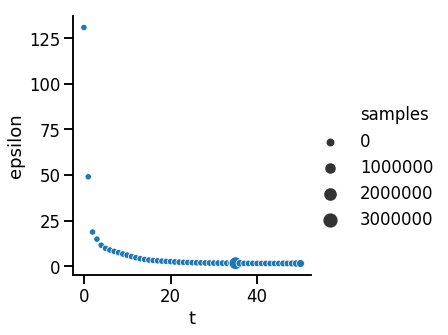

In [10]:
sns.set_context('talk')
evolution = history.get_all_populations()
grid = sns.relplot(x='t', y='epsilon', size='samples', data=evolution[evolution.t>=0])
grid.savefig('results/ina/eps_evolution.pdf')

In [11]:
df, w = history.get_distribution(m=0)

/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/site-packages/pyabc-0.9.1-py3.6.egg/pyabc/storage/history.py:200: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  w_arr = w.w.as_matrix()


/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/site-packages/pyabc-0.9.1-py3.6.egg/pyabc/transition/multivariatenormal.py:64: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  self._X_arr = X.as_matrix()


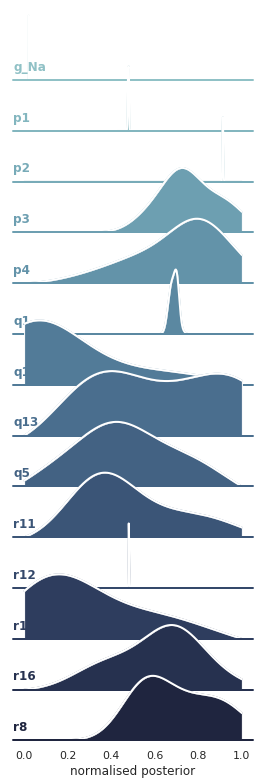

In [13]:
g = plot_parameters_kde(df, w, limits, aspect=5, height=.8)

In [14]:
g.savefig('results/ina/parameters_kde.pdf')

# Samples for quantitative analysis

In [15]:
# Generate parameter samples
n_samples = 100
df, w = history.get_distribution(m=0)
th_samples = df.sample(n=n_samples, weights=w, replace=True).to_dict(orient='records')

/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/site-packages/pyabc-0.9.1-py3.6.egg/pyabc/storage/history.py:200: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  w_arr = w.w.as_matrix()


In [16]:
# Generate sim results samples
samples = pd.DataFrame({})
for i, th in enumerate(th_samples):
    output = model.sample(pars=th, n_x=50)
    output['sample'] = i
    output['distribution'] = 'post'
    samples = samples.append(output, ignore_index=True)

/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


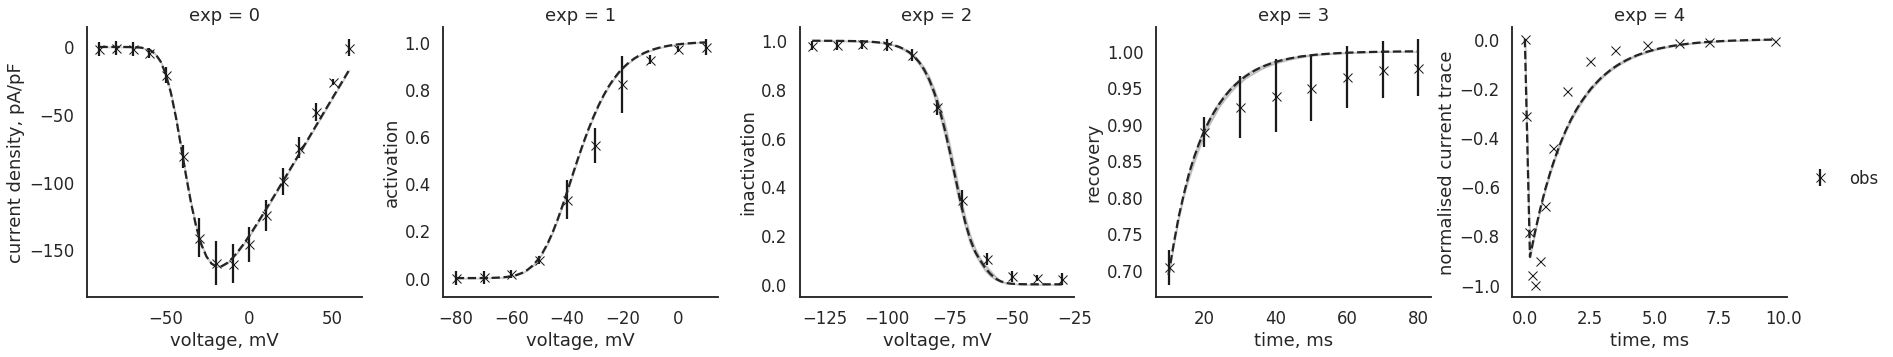

In [34]:
from ionchannelABC import plot_sim_results
sns.set_context('talk')
g = plot_sim_results(samples, obs=measurements)

# Set axis labels
xlabels = ["voltage, mV", "voltage, mV", "voltage, mV", "time, ms", "time, ms"]
ylabels = ["current density, pA/pF", "activation", "inactivation", "recovery", "normalised current trace"]
for ax, xl in zip(g.axes.flatten(), xlabels):
    ax.set_xlabel(xl)
for ax, yl in zip(g.axes.flatten(), ylabels):
    ax.set_ylabel(yl)

In [35]:
g.savefig('results/ina/ina_sim_results.pdf')

In [39]:
# Require discrete samples for exact measurements at -20mV
discrete_samples = pd.DataFrame({})
for i, th in enumerate(th_samples):
    output = model.sample(pars=th)
    output['sample'] = i
    output['distribution'] = 'post'
    discrete_samples = discrete_samples.append(output, ignore_index=True)

In [40]:
# Amplitude at -20 mV
grouped = discrete_samples[discrete_samples['exp']==0].groupby('sample')
def get_amplitude(group):
    return group.loc[group.x==-20]['y']
print(grouped.apply(get_amplitude).mean())
print(grouped.apply(get_amplitude).std())

-162.18620441874845
0.6002147433634896


In [41]:
# Voltage and slope factor at half-activation
from scipy.optimize import curve_fit
grouped = samples[samples['exp']==1].groupby('sample')
def fit_boltzmann(group):
    def boltzmann(V, Vhalf, Shalf):
        return 1/(1+np.exp((Vhalf-V)/Shalf))
    guess = (-50, 10)
    popt, _ = curve_fit(boltzmann, group.x, group.y, guess)
    return popt
output = grouped.apply(fit_boltzmann).apply(pd.Series)

In [42]:
print(output.mean())
print(output.std())

0   -35.597283
1     6.805964
dtype: float64
0    0.146393
1    0.124264
dtype: float64


In [43]:
# Voltage and slope factor at half-inactivation
grouped = samples[samples['exp']==2].groupby('sample')
def fit_boltzmann(group):
    def boltzmann(V, Vhalf, Shalf):
        return 1/(1+np.exp((V-Vhalf)/Shalf))
    guess = (-50, 10)
    popt, _ = curve_fit(boltzmann, group.x, group.y, guess)
    return popt
output = grouped.apply(fit_boltzmann).apply(pd.Series)

In [44]:
print(output.mean())
print(output.std())

0   -74.179791
1     5.281420
dtype: float64
0    1.636682
1    0.277029
dtype: float64
